# <span style="color:green;">**Monte Carlo Pricing**</span>

Recall that, under the risk-neutral measure $\mathbb{Q}$, the forward price follows the dynamics:

\begin{equation*}
dF(t,T) = \sigma F(t,T)dW(t),
\end{equation*}
with $F(0,T)=F_{0}$, $\sigma >0$ is the volatility, $r$ is the risk-free rate and $W = \left\{W(t); t \ge 0\right\}$ is a Brownian motion. 

Assume that you want to determine the price of a call option $C(t_{0},K)$ at time $t_{0}=0$, with maturity $T$ and strike price $K$. From the theory the price is given by the following formula:

\begin{equation*}
    C(t_{0},K) = e^{-r(T-t_{0})}\mathbb{E}^{\mathbb{Q}}\left[(F(T,T) - K)^{+}\right]
\end{equation*}

In the case of the Black76 model the option price can be determinated explicitely, but in many cases no closed form solutions are available. Hence numerical methods, as the Monte Carlo one, must be implemented.


Monte Carlo method gives an approximation of the expected value. The pricing algorithm for an European call option is the following:


 - Simulate many paths by discretizing the SDE of the Black-Scholes model by using (for example) the Euler method. Obtain many samples of $\left\{F(T,T)\right\}_{k},\; k=1,\dots, n$.

 - Evaluate the payoff function $\Phi(x)=\left(x-K\right)^{+}$ for all $\left\{F(T,T)\right\}_{k},\; k=1,\dots, n$. Obtain $\Phi(F(T,T)_{k})$, for  $k=1,\dots,n$.

 - An estimate for the option value is:
 \begin{equation*}
    \hat{C}(t_{0},K) =e^{-r(T-t_{0})} \frac{1}{n} \sum_{k=1}^{n} \Phi(F(T,T)_{k})
\end{equation*}

- The variable \hat{C}(t_{0},K) is a random variable with 
\begin{equation*}
\mathbb{E}^{\mathbb{Q}} \left[\hat{C}(t_{0},K)\right] = C(t_{0},K)
\end{equation*}
    


Okay, now let's do some coding!

In [1]:
# Import what you need
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

SEED = 4  # Set random seed for reproducibility

# Black76 exact formula
def black76_call(F: float, K: float, T: float, r: float, sigma: float):
    """
    This function copute the price of a European call option using the Black-Scholes formula
    :param F: initial fwd price
    :param K: strike price
    :param T: time to maturity
    :param r: risk-free interest rate
    :param sigma: volatility
    """

    d1 = (math.log(F / K) + (sigma**2) / 2 * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)

    # Black-Scholes formula for call price
    call_price = np.exp(-r*T)*(F * N_d1 - K * N_d2)
    return call_price


def geometric_brownian_motion(F: float, sigma: float, T: float, dt: float, n_sim: int):
    """
    Simulates geometric Brownian motion for pricing.
    
    Parameters:
        F (float): Initial fwd price.
        sigma (float): Volatility.
        T (float): Time period (in years).
        dt (float): Time step (in years).
        n_sim (int): Number of simulations.
    
    Returns:
        numpy.ndarray: Array of simulated stock prices.
    """
    num_steps = int(T / dt)
    t = np.linspace(0, T, num_steps)

    simulations = np.zeros((n_sim, num_steps))    
    
    for i in range(n_sim): 
        
        """
        Simulating the whole history of the forward price
        RMK: not exploiting the equivalence in law of the GBM
        """

        W = np.random.standard_normal(size=num_steps) 
        W = np.cumsum(W) * np.sqrt(dt)
        drift = - 0.5 * sigma**2 * t
        diffusion = sigma * W
        simulations[i,:] = F * np.exp(drift + diffusion)
    
    return simulations

In [2]:
# Some parameters for the option pricing
S0 = 100  # Initial stock price
r = 0.05  # Drift or expected return
sigma = 0.2  # Volatility
T = 1  # Time period in years
dt = 1/252  # Time step in years (assuming 252 trading days in a year)
n_sim = 100000 # Number of simulations

closed_form_price = black76_call(S0, S0, T, r, sigma)
print("Closed-form price: ", closed_form_price)

# Simulate prices under risk-neutral measure
np.random.seed(SEED)  # Set the random seed
simulated_prices = geometric_brownian_motion(S0, sigma, T, dt, n_sim)

print("Simulated prices shape: ", simulated_prices.shape)

Closed-form price:  7.57708214642728
Simulated prices shape:  (100000, 252)


Text(0.5, 1.0, 'Simulated prices for 10 days')

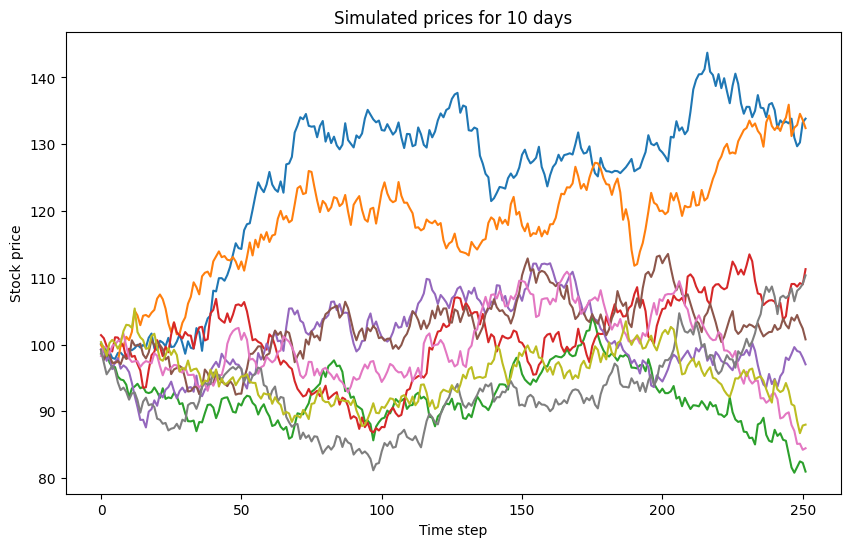

In [3]:
# Plot simulated prices
plt.figure(figsize=(10,6))
plt.plot(simulated_prices[1:10,:].transpose())
plt.xlabel('Time step')
plt.ylabel('Stock price')
plt.title('Simulated prices for {} days'.format(10))

In [6]:
def monte_carlo_european_pricer_dir(S0, sigma, T, dt, n_sim, K, r):
    np.random.seed(SEED)
    g = np.random.standard_normal(size=n_sim)
    ST = S0 * np.exp(-(0.5 * sigma**2) * T + sigma * np.sqrt(T) * g) # exploiting equivalence in law
    payoff = np.maximum(ST - K, 0)
    option_value = np.exp(-r * T)*np.mean(payoff)
    call_option_exact = black76_call(S0, K, T, r, sigma)
    error = np.abs(option_value - call_option_exact)
    return option_value, error

In [5]:
K = 100
monte_carlo_european_pricer_dir(S0, sigma, T, dt, n_sim, K, r)

(7.525344366712613, 0.0517377797146672)

In [6]:
# Implement the function
def monte_carlo_european_pricer(S0, sigma, T, dt, n_sim, K, r):
    np.random.seed(SEED)
    simulated_prices = geometric_brownian_motion(S0, sigma, T, dt, n_sim)
    payoff = np.maximum(simulated_prices[:,-1] - K, 0)
    call_option_monte_carlo = np.exp(-r*T)*np.mean(payoff)
    call_option_exact = black76_call(S0, K, T, r, sigma)
    #print(f'Monte Carlo price: {call_option_monte_carlo}')
    #print(f'Exact price: {call_option_exact}')
    error = np.abs(call_option_monte_carlo - call_option_exact)
    return call_option_monte_carlo, error

In [7]:
K = 100
monte_carlo_european_pricer(S0, sigma, T, dt, n_sim, K, r)

(7.516875677931267, 0.06020646849601263)

In [8]:
def Euler_method(S0, sigma, T, dt, n_sim):
    
    num_steps = int(T / dt)
    
    F = np.zeros((n_sim, num_steps+1))
    F[:, 0] = S0
    for i in range(num_steps):
        F[:, i+1] = F[:, i]*(1 + sigma*np.random.standard_normal(n_sim) * np.sqrt(dt))
    
    return F[:, 1:] # dropping the initial price

In [9]:
def monte_carlo_european_pricer_Euler(S0, sigma, T, dt, n_sim, K, r):
    np.random.seed(SEED)
    
    simulated_prices = Euler_method(S0, sigma, T, dt, n_sim) # the simulation in terms of GBM gives you different paths of the stock price
    
    payoff = np.maximum(simulated_prices[:,-1] - K, 0) # call option payoff at maturity, from all the simulations, give me the last price of the stock and calculate the payoff
    
    call_option_monte_carlo = np.exp(-r*T)*np.mean(payoff) # np.exp(-r*T) present value of the payoff
    
    call_option_exact = black76_call(S0, K, T, r, sigma)
    #print(f'Monte Carlo price: {call_option_monte_carlo}')
    #print(f'Exact price: {call_option_exact}')
    error = np.abs(call_option_monte_carlo - call_option_exact)
    return call_option_monte_carlo, error

Simulated prices shape:  (100000, 252)


Text(0.5, 1.0, 'Simulated prices for 10 days')

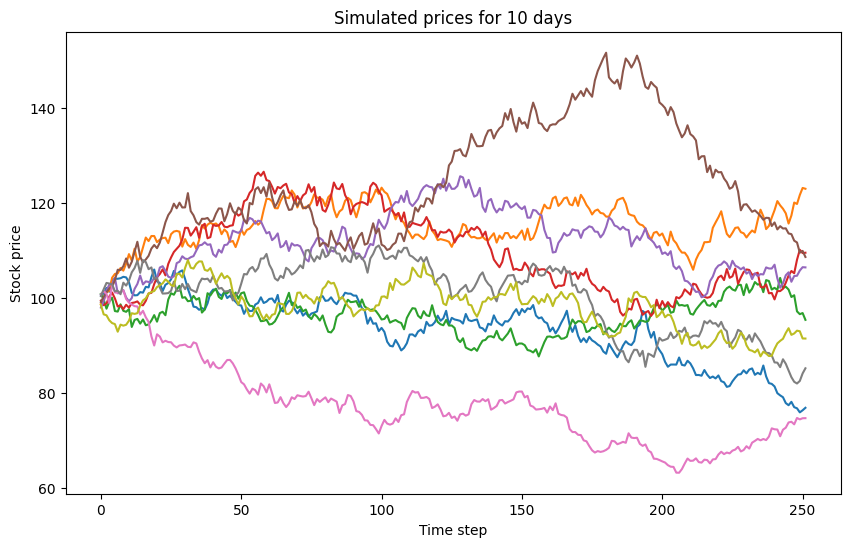

In [10]:
# Some parameters for the option pricing
S0 = 100  # Initial stock price
r = 0.05  # Drift or expected return
sigma = 0.2  # Volatility
T = 1  # Time period in years
dt = 1/252  # Time step in years (assuming 252 trading days in a year)
n_sim = 100000 # Number of simulations

# Simulate prices under risk-neutral measure
np.random.seed(SEED)  # Set the random seed
simulated_prices = Euler_method(S0, sigma, T, dt, n_sim)

print("Simulated prices shape: ", simulated_prices.shape)

# Plot simulated prices
plt.figure(figsize=(10,6))
plt.plot(simulated_prices[1:10,:].transpose())
plt.xlabel('Time step')
plt.ylabel('Stock price')
plt.title('Simulated prices for {} days'.format(10))

In [11]:
K = 100
monte_carlo_european_pricer_Euler(S0, sigma, T, dt, n_sim, K, r)

(7.526155896596568, 0.050926249830712145)

In [12]:
# Check that the Monte Carlo method converges to the exact solution
n_sim_vec = [10, 100, 500, 1000, 2000, 5000, 10000, 25000, 50000, 75000, 100000, 200000]


call_option_monte_carlo = np.zeros(len(n_sim_vec))  # Inizialize to zero the vector of monte carlo call option prices
errors_mc = np.zeros(len(n_sim_vec))

# Loop: Compute the price by varying the number of simulations, compute the error and show that the order of convergence of
# the monte carlo method is 1/sqrt(N).
for i, n_sim in enumerate(n_sim_vec):
    print (f"Number of simulations: {n_sim:6d}")
    price, err = monte_carlo_european_pricer_dir(S0, sigma, T, dt, n_sim, K, r)
    call_option_monte_carlo[i] = price
    errors_mc[i] = err
    print(f"Error: {err}")

Number of simulations:     10
Error: 4.13617615308624
Number of simulations:    100
Error: 0.04850713054633182
Number of simulations:    500
Error: 0.46420098211074645
Number of simulations:   1000
Error: 0.07402546909252994
Number of simulations:   2000
Error: 0.053513700051230906
Number of simulations:   5000
Error: 0.10624526606600782
Number of simulations:  10000
Error: 0.0267943684972467
Number of simulations:  25000
Error: 0.03153522503717632
Number of simulations:  50000
Error: 0.03008795534386266
Number of simulations:  75000
Error: 0.059495320009494534
Number of simulations: 100000
Error: 0.0517377797146672
Number of simulations: 200000
Error: 0.06991768385052755


Text(0.5, 1.0, 'Error with number of simulations')

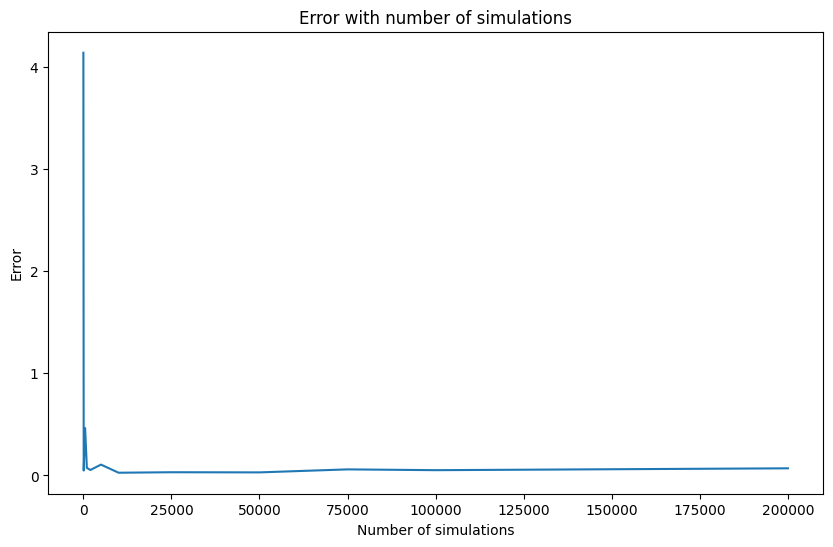

In [13]:
# Plot the results: show the plot here
# Plot simulated prices
plt.figure(figsize=(10,6))
plt.plot(n_sim_vec, errors_mc.transpose())
plt.xlabel('Number of simulations')
plt.ylabel('Error')
plt.title('Error with number of simulations')

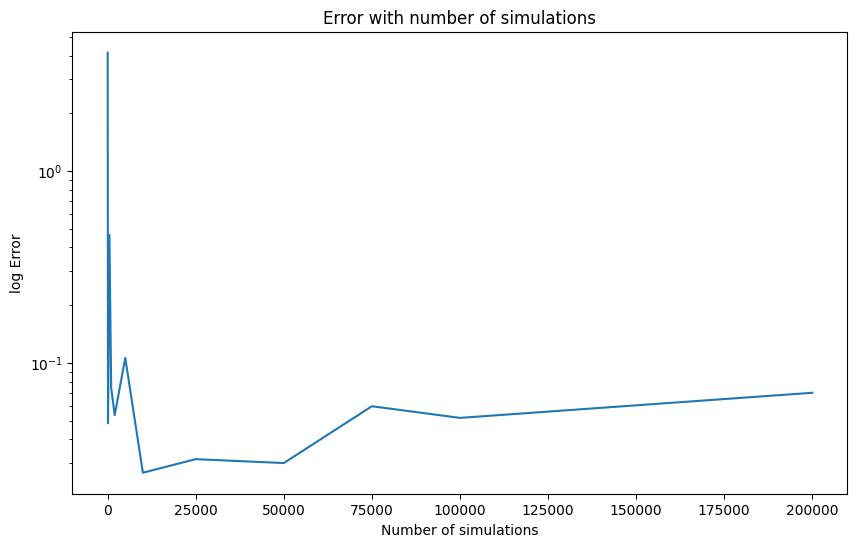

In [14]:
plt.figure(figsize=(10,6))
plt.plot(n_sim_vec,errors_mc.transpose())
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.xlabel('Number of simulations')
plt.ylabel('log Error')
plt.title('Error with number of simulations')
plt.show()

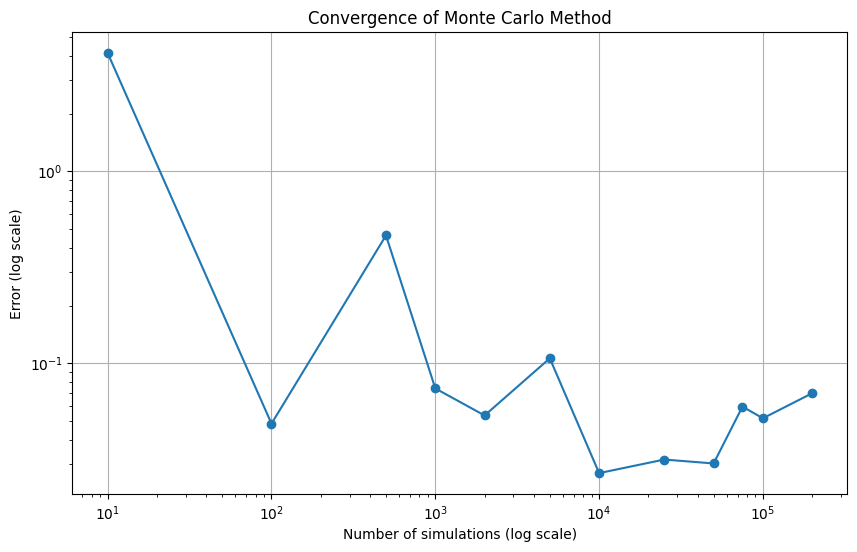

In [15]:
# Perform log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(n_sim_vec, errors_mc, marker='o', linestyle='-')
plt.xlabel('Number of simulations (log scale)')
plt.ylabel('Error (log scale)')
plt.title('Convergence of Monte Carlo Method')
plt.grid(True)
plt.show()

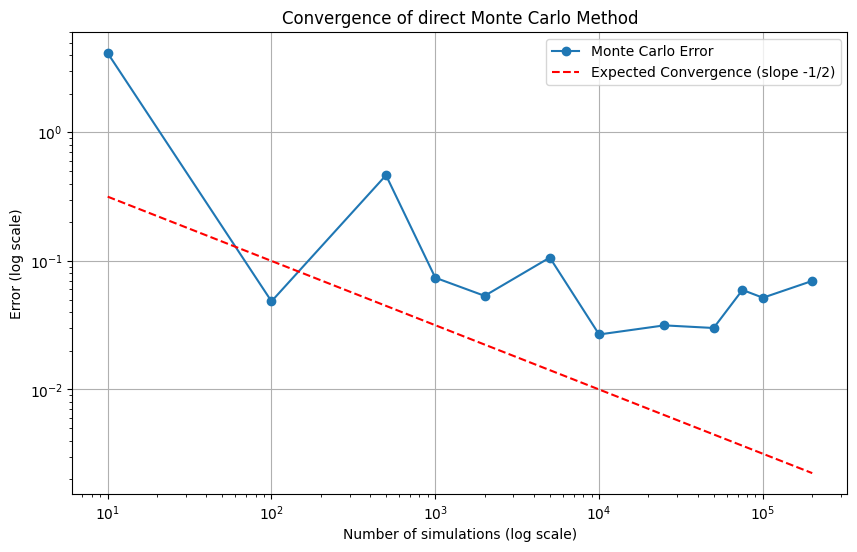

In [16]:
# Perform log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(n_sim_vec, errors_mc, marker='o', linestyle='-', label='Monte Carlo Error')

# Plot the expected convergence line with slope -1/2
expected_errors = 1 / np.sqrt(n_sim_vec)
plt.loglog(n_sim_vec, expected_errors, 'r--', label='Expected Convergence (slope -1/2)')

plt.xlabel('Number of simulations (log scale)')
plt.ylabel('Error (log scale)')
plt.title('Convergence of direct Monte Carlo Method')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
# Check that the Monte Carlo method converges to the exact solution
n_sim_vec = [10, 100, 500, 1000, 2000, 5000, 10000, 25000, 50000, 75000, 100000, 200000]


call_option_monte_carlo = np.zeros(len(n_sim_vec))  # Inizialize to zero the vector of monte carlo call option prices
errors_mc = np.zeros(len(n_sim_vec))

# Loop: Compute the price by varying the number of simulations, compute the error and show that the order of convergence of
# the monte carlo method is 1/sqrt(N).
for i, n_sim in enumerate(n_sim_vec):
    print (f"Number of simulations: {n_sim:6d}")
    price, err = monte_carlo_european_pricer_Euler(S0, sigma, T, dt, n_sim, K, r)
    call_option_monte_carlo[i] = price
    errors_mc[i] = err
    print(f"Error: {err}")

Number of simulations:     10
Error: 5.069526212092702
Number of simulations:    100
Error: 0.22309404026949853
Number of simulations:    500
Error: 0.5594940044739012
Number of simulations:   1000
Error: 0.5483463786759115
Number of simulations:   2000
Error: 0.5064573119212632
Number of simulations:   5000
Error: 0.3961022431711312
Number of simulations:  10000
Error: 0.22705369993149294
Number of simulations:  25000
Error: 0.10294406736401207
Number of simulations:  50000
Error: 0.1296749372634256
Number of simulations:  75000
Error: 0.07057180843928634
Number of simulations: 100000
Error: 0.050926249830712145
Number of simulations: 200000
Error: 0.05448277356551401


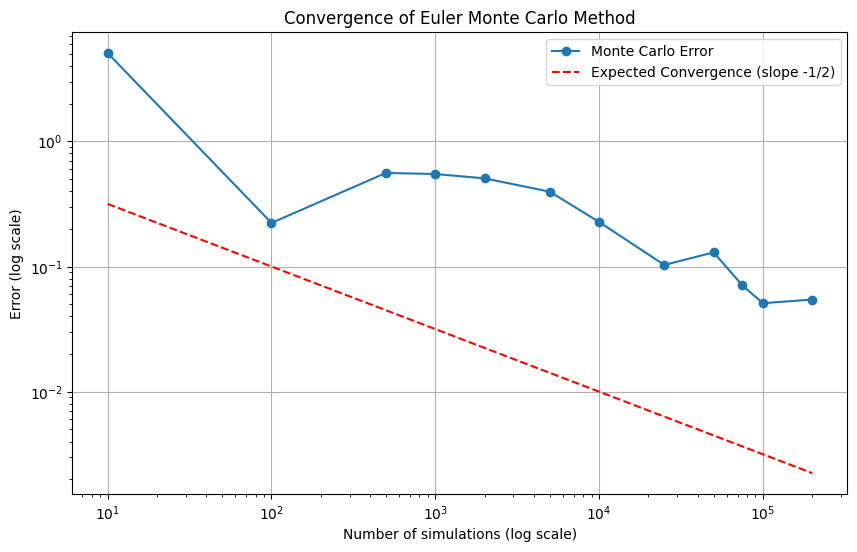

In [18]:
# Perform log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(n_sim_vec, errors_mc, marker='o', linestyle='-', label='Monte Carlo Error')

# Plot the expected convergence line with slope -1/2
expected_errors = 1 / np.sqrt(n_sim_vec)
plt.loglog(n_sim_vec, expected_errors, 'r--', label='Expected Convergence (slope -1/2)')

plt.xlabel('Number of simulations (log scale)')
plt.ylabel('Error (log scale)')
plt.title('Convergence of Euler Monte Carlo Method')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
# Check that the Monte Carlo method converges to the exact solution
n_sim_vec = [10, 100, 500, 1000, 2000, 5000, 10000, 25000, 50000, 75000, 100000, 200000]


call_option_monte_carlo = np.zeros(len(n_sim_vec))  # Inizialize to zero the vector of monte carlo call option prices
errors_mc = np.zeros(len(n_sim_vec))

# Loop: Compute the price by varying the number of simulations, compute the error and show that the order of convergence of
# the monte carlo method is 1/sqrt(N).
for i, n_sim in enumerate(n_sim_vec):
    print (f"Number of simulations: {n_sim:6d}")
    price, err = monte_carlo_european_pricer(S0, sigma, T, dt, n_sim, K, r)
    call_option_monte_carlo[i] = price
    errors_mc[i] = err
    print(f"Error: {err}")

Number of simulations:     10
Error: 2.4144222847060863
Number of simulations:    100
Error: 1.7170691010938297
Number of simulations:    500
Error: 1.3119752700743907
Number of simulations:   1000
Error: 1.3313399359251763
Number of simulations:   2000
Error: 0.8445122845051891
Number of simulations:   5000
Error: 0.6773517719970696
Number of simulations:  10000
Error: 0.25148110848352445
Number of simulations:  25000
Error: 0.08110428749958487
Number of simulations:  50000
Error: 0.08997648916825263
Number of simulations:  75000
Error: 0.10580730226746216
Number of simulations: 100000
Error: 0.06020646849601263
Number of simulations: 200000
Error: 0.03837187691576105


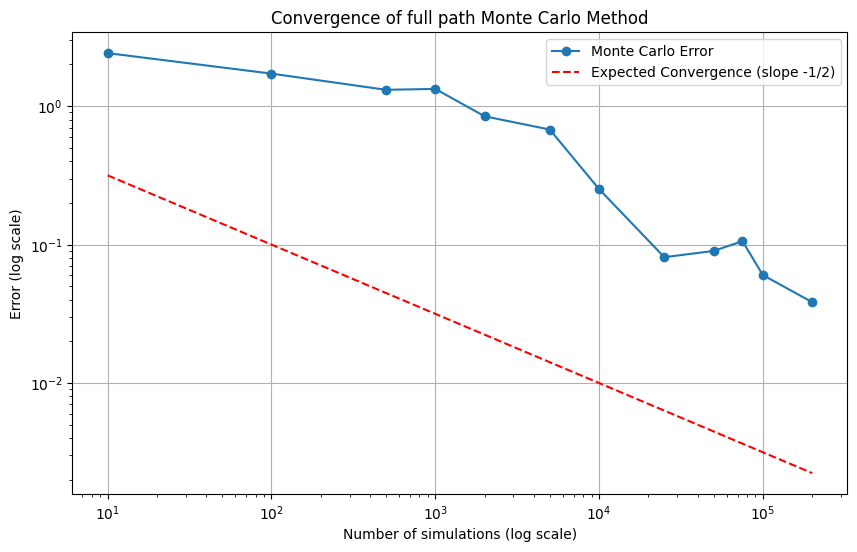

In [20]:
# Perform log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(n_sim_vec, errors_mc, marker='o', linestyle='-', label='Monte Carlo Error')

# Plot the expected convergence line with slope -1/2
expected_errors = 1 / np.sqrt(n_sim_vec)
plt.loglog(n_sim_vec, expected_errors, 'r--', label='Expected Convergence (slope -1/2)')

plt.xlabel('Number of simulations (log scale)')
plt.ylabel('Error (log scale)')
plt.title('Convergence of full path Monte Carlo Method')
plt.grid(True)
plt.legend()
plt.show()